In [1]:
import zhinst
import zhinst.utils
import zhinst.ziPython as ziPython
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt

In [2]:
master_id = 'dev4299' ###### Change master device here  ######
slave_id = 'dev4614' ###### Change slave here  ######

num_samples = 2**12 ## How many number of samples to take? 

devs = [master_id, slave_id]

repeats = int(1e4) ##### How many cross-correlation averages do you want to take?

In [3]:
apilevel = 6

daq =  zhinst.ziPython.ziDAQServer('127.0.0.1', 8004, apilevel)
discovery = zhinst.ziPython.ziDiscovery()

# Enable the API's log.
daq.setDebugLevel(3)

## Get Master and slave daq handles
master = discovery.find(master_id).lower()
slave = discovery.find(slave_id).lower()

# Reverts all settings in devices back to default
zhinst.utils.disable_everything(daq, master)
zhinst.utils.disable_everything(daq, slave)

tbase = daq.getDouble('/%s/system/properties/timebase' % master_id)

[['/dev4614/currins/*/float', 0],
 ['/dev4614/dios/*/drive', 0],
 ['/dev4614/demods/*/enable', 0],
 ['/dev4614/demods/*/trigger', 0],
 ['/dev4614/demods/*/sinc', 0],
 ['/dev4614/demods/*/oscselect', 0],
 ['/dev4614/demods/*/harmonic', 1],
 ['/dev4614/demods/*/phaseshift', 0],
 ['/dev4614/extrefs/*/enable', 0],
 ['/dev4614/mods/*/enable', 0],
 ['/dev4614/pids/*/enable', 0],
 ['/dev4614/sigins/*/ac', 0],
 ['/dev4614/sigins/*/imp50', 0],
 ['/dev4614/sigins/*/diff', 0],
 ['/dev4614/sigins/*/float', 0],
 ['/dev4614/sigouts/*/on', 0],
 ['/dev4614/sigouts/*/enables/*', 0],
 ['/dev4614/sigouts/*/offset', 0.0],
 ['/dev4614/sigouts/*/add', 0],
 ['/dev4614/sigouts/*/diff', 0],
 ['/dev4614/sigouts/*/imp50', 0],
 ['/dev4614/scopes/*/enable', 0],
 ['/dev4614/scopes/*/segments/enable', 0],
 ['/dev4614/scopes/*/stream/enables/*', 0],
 ['/dev4614/triggers/out/*/drive', 0]]

In [4]:
####################################################################################################################
# Configure the MFLI settings for the test experiment
####################################################################################################################

# Set signal to be outputted from master device
daq.setDouble('/%s/oscs/0/freq' % master_id, 66900) # Set oscillator frequency to 66.9 kHz
daq.setDouble('/%s/sigouts/0/range' % master_id, 0.005) # Set input range to 1.0m
daq.setDouble('/%s/sigouts/0/amplitudes/0' % master_id, 7e-06) # Set amplitude of signal to be outputted
daq.setInt('/%s/sigouts/0/on' % master_id, 1) # Enable signal output
daq.setInt('/%s/sigouts/0/enables/0' % master_id, 1) # Enable amplitud eoutput
daq.setInt('/%s/sigouts/0/imp50' % master_id, 1) # Turn on output impedance

daq.setDouble('/%s/sigins/0/range' % master_id, 0.001) # Set input range
daq.setInt('/%s/sigins/0/imp50' % master_id, 1) #  Turn on input impedance

daq.setDouble('/%s/sigins/0/range' % slave_id, 0.001) # Set input range
daq.setInt('/%s/sigins/0/imp50' % slave_id, 1) #  Turn on input impedance

In [9]:
daq.setDouble('/%s/sigins/0/range' % slave_id, 0.01) # Set input range

In [12]:
# capture several scope shots
poll_length = 0.1  # [s]
poll_timeout = 100  # [ms]
poll_flags = 0
poll_return_flat_dict = True

# compare each device to the base device
data = {}

print("Starting measurements between %s and %s" % (master_id, slave_id))

daq.unsubscribe('*')
daq.subscribe('/%s/scopes/0/wave' % master_id)
daq.subscribe('/%s/scopes/0/wave' % slave_id)
daq.setInt('/%s/scopes/0/single' % master_id, 1)
daq.setInt('/%s/scopes/0/single' % slave_id, 1)
daq.setInt('/%s/scopes/0/enable' % master_id, 1)
daq.setInt('/%s/scopes/0/enable' % slave_id, 1)
daq.sync()
time.sleep(0.5)

# set output (trigger scope shot)
daq.setDouble('/%s/sigouts/0/offset' % master_id, 1.0)
time.sleep(0.1)
daq.setDouble('/%s/sigouts/0/offset' % master_id, 0.0)

d = daq.poll(poll_length, poll_timeout, poll_flags, poll_return_flat_dict)

if not '/%s/scopes/0/wave' % slave_id in d or not '/%s/scopes/0/wave' % master_id in d:
    assert False

data[slave_id] = d
data[master_id] = d

daq.unsubscribe('*')

Starting measurements between dev4299 and dev4614


In [52]:
##### Read and plot data from master device ####

path = '/%s/scopes/0/wave' % master_id
#Get clockbase of master device
clockbase = daq.getInt('/{}/clockbase'.format(master_id))

# Find convert the timestamps to the relative time captured from master device
dt = data[master_id][path][0]['dt']
totalsamples = data[master_id][path][0]['totalsamples']
timestamp = data[master_id][path][0]['timestamp']
triggerTimestamp = data[master_id][path][0]['triggertimestamp']
xtime = np.linspace(0, dt*totalsamples, totalsamples) # This is the time starting from 0
relativeTime1 = xtime - (timestamp - triggerTimestamp)/float(clockbase) # This is the time as actually captured in scope

# Get wave captured from master device
scope_shot = data[master_id][path]
scope_shot = scope_shot[-1]
wave1 = (scope_shot['channeloffset'][0] + scope_shot['channelscaling'][0] * scope_shot['wave'][:, 0])

##### Read and plot data from slave device ####

path = '/%s/scopes/0/wave' % slave_id
#Get clockbase of slave device
clockbase = daq.getInt('/{}/clockbase'.format(slave_id))

# Find convert the timestamps to the relative time captured from slave device
dt = data[slave_id][path][0]['dt']
totalsamples = data[slave_id][path][0]['totalsamples']
timestamp = data[slave_id][path][0]['timestamp']
triggerTimestamp = data[slave_id][path][0]['triggertimestamp']
xtime = np.linspace(0, dt*totalsamples, totalsamples) # This is the time starting from 0
relativeTime2 = xtime - (timestamp - triggerTimestamp)/float(clockbase) # This is the time as actually captured in scope

# Get wave captured from slave device
scope_shot = data[slave_id][path]
scope_shot = scope_shot[-1]
wave2 = (scope_shot['channeloffset'][0] + scope_shot['channelscaling'][0] * scope_shot['wave'][:, 0])

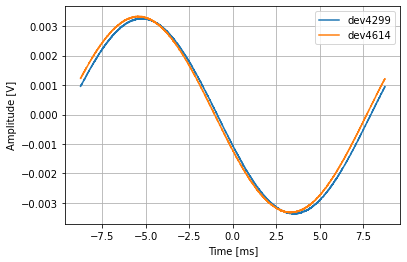

In [53]:
plt.plot(relativeTime1 * 1e3, wave1, label=master_id)
plt.plot(relativeTime2 * 1e3, wave2, label=slave_id)

plt.ylabel('Amplitude [V]')
plt.xlabel('Time [ms]')
 
plt.grid(True)
plt.legend()
 
plt.draw()
plt.show()